# Pré-traitement de nos images

Le code ci-dessous permet de réaliser un pré-traitement en supposant l'emplacement de la forme dans l'image. L'utilisateur appuie sur la touche Espace si l'emplacement prédit est correct ou sinon il trace lui-même l'emplacement prédit.  
  
Un dossier d'erreur est créé avec les images qui n'ont pas de contour prédits, nous les avons annoté à la main mais nous aurions pu nous contenter des images prédites qui, même si elles peuvent comporter des erreurs, sont plus rapides à nettoyer car elles ont majoritairement un contour correctement prédit.

In [ ]:
import cv2
import os

current_dir = './Labo_2/'
data_dir = current_dir + 'data/'
export_folder =  current_dir + 'output/'
clean_data_folder = export_folder + 'clean/'
error_data_folder = export_folder + 'error/'

good_prediction = 0
bad_prediction = 0

for i in os.listdir(data_dir) :
    for j in os.listdir(data_dir + str(i)) :
        index = 0
        for k in os.listdir(data_dir + str(i) + '/' + str(j)) : # on boucle sur toutes les images du jeu de données
            if not os.path.isfile(clean_data_folder + str(i) + '/' + str(j) + '/' + str(k)): 
                index += 1
                if index < 10000 :
                    image = cv2.imread(data_dir + str(i) + '/' + str(j) + '/' + str(k))
                    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # on passe l'image en niveau de gris
                    img_blur = cv2.GaussianBlur(img_gray, (9,9), 0) # flou pour aider à la distinction des contours
                    edged = cv2.Canny(img_blur, 30,120) # Canny fonctionne comme un double threshold

                    # on cherche des contours sur les images
                    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    img_output = img_gray
                    img_view = image.copy()

                    x,y,w,h = 0,0,0,0

                    # on trace les contours qui ont une aire acceptable
                    for c in contours :
                        area = cv2.contourArea(c)
                        if area > 400 :
                            x,y,w,h = cv2.boundingRect(c)
                            cv2.rectangle(img_view, (x, y), (x + w, y + h), (36, 255, 12), 2) #crée une bbox verte

                    os.makedirs(clean_data_folder + str(i) + '/' + str(j) + '/', exist_ok=True)
                    os.makedirs(error_data_folder + str(i) + '/' + str(j) + '/', exist_ok=True)

                    print(str(k))
                    rect = cv2.selectROI(img=img_view, windowName=str(k))
                    cv2.destroyAllWindows()
                    if rect == (0,0,0,0) :
                        img_output = image[y:y+h,x:x+w]
                        
                    else :
                        img_output = image[int(rect[1]):int(rect[1]+rect[3]), int(rect[0]):int(rect[0]+rect[2])]

                    # on redimensionne les images en 40x40 pour que la détection soit plus efficace
                    img_output = cv2.resize(img_output,dsize=(40,40), interpolation=cv2.INTER_AREA)
                    cv2.imwrite(clean_data_folder + str(i) + '/' + str(j) + '/' + str(k), img_output)
                    good_prediction += 1

# Augmentation des données

On crée une fonction qui va générer 8 images transformées pour une seule image initiale :

In [1]:
import cv2

# returns 8 tuples (name_suffix, image)
def generate_variations(image):
    return (
        ('', image),
        ('_90', cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)),
        ('_180', cv2.rotate(image, cv2.ROTATE_180)),
        ('_270', cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)),
        ('_flip', cv2.flip(image, 0)),
        ('_flip_90', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_90_CLOCKWISE)),
        ('_flip_180', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_180)),
        ('_flip_270', cv2.rotate(cv2.flip(image, 0), cv2.ROTATE_90_COUNTERCLOCKWISE)),
    )

On applique la fonction d'augmentation sur nos images :

In [5]:
import os

current_dir = '../'
data_dir = current_dir + 'output/clean/'
augmented_data_dir = current_dir + 'output/augmented/'

indice = 0
for i in os.listdir(data_dir) :
    for j in os.listdir(data_dir + str(i)) :
        for k in os.listdir(data_dir + str(i) + '/' + str(j)) :
            if not os.path.isfile(augmented_data_dir + str(i) + '/' + str(j) + '/' + str(k)) :
                indice += 1
                image = cv2.imread(data_dir + str(i) + '/' + str(j) + '/' + str(k))
                img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
                
                os.makedirs(augmented_data_dir + str(i) + '/' + str(j) + '/', exist_ok=True)

                for (sufix,img_output) in generate_variations(img_blur) :
                    cv2.imwrite(augmented_data_dir + str(i) + '/' + str(j) + '/' + str(k).split('.')[0] + sufix + '.jpg', img_output)
                    
print('{} images augmentées'.format(indice))

2439 images augmentées


# Primitives

In [1]:
# Juneau tu peux placer ton code ici pour les graphiques des primitives + ajouter les explications au markdown

In [1]:
%pip install scikit-image

from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import closing
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import numpy as np


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
def solo_features(image):
    df = pd.DataFrame()
    image = imread(image)
    if len(image.shape) == 3 : image = rgb2gray(imread(image))
    binary = image < threshold_otsu(image)
    binary = closing(binary)
    label_img = label(binary)

    table = pd.DataFrame(regionprops_table(label_img, image,
                            ['convex_area', 'area', 'eccentricity',
                            'extent', 'inertia_tensor',                         
                            'major_axis_length', 'minor_axis_length',
                            'perimeter', 'solidity', 'image',
                            'orientation', 'moments_central',
                            'moments_hu', 'euler_number',
                            'equivalent_diameter',
                            'mean_intensity', 'bbox']))
    table['perimeter_area_ratio'] = table['perimeter']/table['area']
    real_images = []
    std = []
    mean = []
    percent25 = []
    percent75 = []

    for prop in regionprops(label_img): 
        min_row, min_col, max_row, max_col = prop.bbox
        img = image[min_row:max_row,min_col:max_col]
        real_images += [img]
        mean += [np.mean(img)]
        std += [np.std(img)]
        percent25 += [np.percentile(img, 25)] 
        percent75 += [np.percentile(img, 75)]

    table['real_images'] = real_images
    table['mean_intensity'] = mean
    table['std_intensity'] = std
    table['25th Percentile'] = mean
    table['75th Percentile'] = std
    table['iqr'] = table['75th Percentile'] - table['25th Percentile']
    table['label'] = 'img'
    df = pd.concat([df, table], axis=0)
    df.head()

    #features
    X = df[['area','extent', 'eccentricity','perimeter_area_ratio','std_intensity', 'mean_intensity','perimeter', 'solidity', 'convex_area', 'iqr', 'euler_number', 'equivalent_diameter', 'orientation','inertia_tensor-0-0',
            'moments_central-0-0','moments_central-0-2','moments_central-2-0','moments_central-2-2','moments_hu-2','moments_hu-6']]

    count = len(X.index)
    features = X.mean().to_dict()
    features['nb_contours'] = count
    
    return features

In [3]:
solo_features('../output/augmented/Cercles/Cercle5/1_Cercle5_90.jpg')

{'area': 286.0,
 'extent': 0.52125,
 'eccentricity': 0.6378512682874985,
 'perimeter_area_ratio': 0.7124159977970757,
 'std_intensity': 48.53417283165064,
 'mean_intensity': 90.42104166666667,
 'perimeter': 131.43418707023054,
 'solidity': 0.7589981242414212,
 'convex_area': 546.6666666666666,
 'iqr': -41.88686883501602,
 'euler_number': 0.6666666666666666,
 'equivalent_diameter': 14.079342887286481,
 'orientation': 0.5696239780215264,
 'inertia_tensor-0-0': 51.77252316411978,
 'moments_central-0-0': 286.0,
 'moments_central-0-2': 40706.43078827783,
 'moments_central-2-0': 42907.69670835736,
 'moments_central-2-2': 6243252.918054325,
 'moments_hu-2': 0.0002487461667192578,
 'moments_hu-6': -3.7638095293295405e-08,
 'nb_contours': 3}

***

# Notre réseau de neurones

In [2]:
# Victor, tu peux mettre ici le code pour ton réseau de neurones, avec les explications et la justification du choix des hyper-paramètres

***

# Comparaison des modèles

In [3]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
import numpy as np
import os
from PIL import Image
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score, auc, \
    roc_curve, confusion_matrix, classification_report, accuracy_score, \
        cohen_kappa_score, roc_auc_score, roc_curve

### Chargement et visualisation de notre jeu de données

#### Définition du dataset

Notre my_dataset est stocké au sein d'une classe :

In [5]:
class dataset():
    def __init__(self, root,nb_max=None) :
        self.root = root
        self.data = np.array([], dtype=np.int32)
        self.target = np.array([], dtype=np.int32)
        self.target_names = np.array([], dtype=np.int32)
        self.feature_names = np.array([], dtype=np.int32)

        nb_class = 0
        nb_images = 0

        # on parcourt les images pour remplir le my_dataset
        for i in os.listdir(self.root) :
            if nb_max is None or nb_images < nb_max :
                for j in os.listdir(self.root + str(i)) :
                    if nb_max is None or nb_images < nb_max :
                        self.target_names = np.append(self.target_names,j)
                        nb_class += 1
                        for k in os.listdir(self.root + str(i) + '/' + str(j)) :
                            if nb_max is None or nb_images < nb_max :
                                if nb_images%1000 == 0 :
                                    print('{} images importées'.format(nb_images))
                                #on ajoute la sortie
                                self.target = np.append(self.target,nb_class)
                                
                                #on ajoute tous les pixels en features
                                img = Image.open(self.root + str(i) + '/' + str(j) + '/' + str(k)).convert('L')
                                self.data = np.append(self.data,np.asarray(img))

                                # on ajoute les features qu'on a implémenté en plus des pixels
                                other_features = solo_features(self.root + str(i) + '/' + str(j) + '/' + str(k))
                                self.data = np.append(self.data, np.asarray(list(other_features.values())))
                                
                                nb_images += 1
        print('{} images importées'.format(nb_images))

        self.data = np.reshape(self.data,(nb_images,1621))
        
        # on ajoute des noms aux features des pixels
        for i in range(40) :
            for j in range(40) :
                self.feature_names = np.append(self.feature_names,'pixels ' + str(i) + '_' + str(j))
        
        # enfin, on ajout les noms des features qu'on a implémenté
        for i in range(21) :
            self.feature_names = np.append(self.feature_names, 'primitive_perso_{}'.format(i))     
        

    
    def normalize(self):
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)

#### Instanciation du dataset (si vous ne possédez pas le fichier du dataset)

On instancie un dataset avec nos images augmentées :  
**NB : Vous n'avez pas besoin de faire ça si vous avez le fichier** `my_dataset.p`

In [10]:
my_dataset = dataset('../output/augmented/')

my_dataset.data.shape

0 images importées
1000 images importées
2000 images importées
3000 images importées
4000 images importées
5000 images importées
6000 images importées
7000 images importées
8000 images importées
9000 images importées
10000 images importées
11000 images importées
12000 images importées
13000 images importées
14000 images importées
15000 images importées
16000 images importées
17000 images importées
18000 images importées
19000 images importées
19512 images importées


(19512, 1621)

La celulle suivant permet de sauvegarder le dataset dans un fichier à l'aide de `pickle` :

In [12]:
import pickle
from os.path import isfile

if not isfile('my_dataset.p') :
    with open('my_dataset.p', 'wb') as my_dataset_file :
        pickle.dump(my_dataset, my_dataset_file, protocol=pickle.HIGHEST_PROTOCOL)

#### Import du dataset (si vous avez le fichier du dataset)

Pour importer le dataset via le fichier créé, exécutez la cellule suivante :

In [7]:
import pickle

my_dataset = pickle.load(open('my_dataset.p','rb'))

my_dataset.data.shape

(19512, 1621)

#### Normalisation du dataset

On normalise le my_dataset pour obtenir des meilleurs résultats :

In [8]:
print(np.mean(my_dataset.data[:,0]))

my_dataset.normalize()

print(np.mean(my_dataset.data[:,0]))

142.5528905289053
0.5484051828470092


### Préparation du dataset

On divise le dataset en deux, les données et les résultats :

In [9]:
X = my_dataset.data 
Y = my_dataset.target

print(X.shape)
print(Y.shape)

(19512, 1621)
(19512,)


On modifie Y pour qu'il contienne  tous les résultats en un vecteur :

In [10]:
from sklearn.preprocessing import label_binarize

# on modifie le nombre de classes en fonction du dataset directement
Y = label_binarize(Y, classes=range(len(my_dataset.target_names)))
print(Y.shape)


(19512, 8)


On divise le dataset en des ensembles d'entrainement, de test et de validation :

In [11]:
# test_size correspond à la proportion de test, ici 40%
# random_state sert à garder la même valeur d'aléatoire d'un appel de fonction à l'autre lorsqu'on mélange les données  
x_train_val,x_test,y_train_val,y_test = train_test_split(X, Y, test_size=0.2,random_state=4)

# on crée un troisième jeu de données, celui de validation
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val, test_size=0.25,random_state=2)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(11706, 1621) (11706, 8)
(3903, 1621) (3903, 8)
(3903, 1621) (3903, 8)


## Modèles d'apprentissage : KNN, SVM, NN et CNN

### Avec 100% des données (c'est la version la plus expliquée, les autres étant des copies)

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [12]:
# on teste différentes valeurs de k pour trouver le meilleur résultat
k_range = range(1,15)
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train,y_train) 
        y_pred=knn.predict(x_val) # on teste les hyper-paramètres avec l'ensemble de validation
        print('k = {}\t=>\tscore = {:2.3%}'.format(k,metrics.accuracy_score(y_val,y_pred)))

k = 1	=>	score = 91.263%
k = 2	=>	score = 85.293%
k = 3	=>	score = 88.778%
k = 4	=>	score = 83.602%
k = 5	=>	score = 86.062%
k = 6	=>	score = 82.578%
k = 7	=>	score = 84.038%
k = 8	=>	score = 80.297%
k = 9	=>	score = 81.425%
k = 10	=>	score = 78.786%
k = 11	=>	score = 79.862%
k = 12	=>	score = 76.685%
k = 13	=>	score = 77.633%
k = 14	=>	score = 75.045%


Après étude des résultats de la cellule précédente, on choisit k=1, ce qui donne le meilleur résultat pour nos données.

On entraine le modèle :  
  
*NB : Pour chaque entrainement et test, on mesure le temps en prenant le temps `start` de début et le temps `end` de fin d'exécution*  

In [13]:
import time

knn_n_neighbors = 1

start = time.time()

knn = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn.fit(x_train_val,y_train_val) # on combine l'ensemble d'entrainement et de validation pour avoir plus de données

end = time.time()

training_time_knn = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn))

temps d'apprentissage : 0.040 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [14]:
start = time.time()

y_pred_knn = knn.predict(x_test)

end = time.time()

testing_time_knn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn))

temps de test : 2.298 secondes


##### C- Évaluation

On affiche la matrice de confusion de la prédiction :

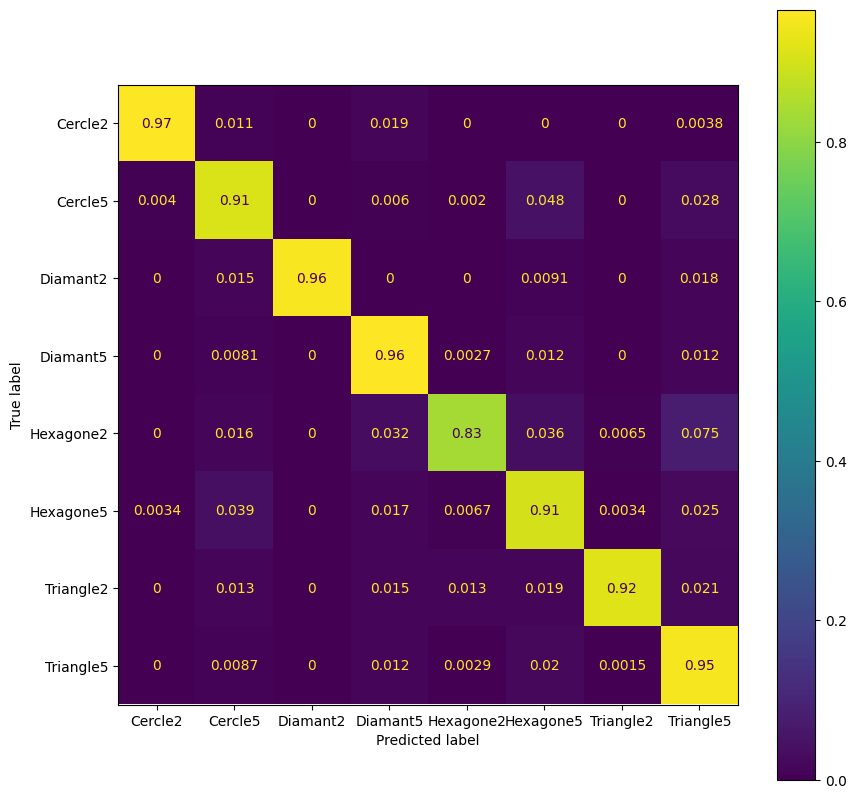

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# on récupère le nom des classes
class_names = my_dataset.target_names.tolist()

# on crée la matrice de confusion
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_knn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10)) # on agrandit la matrice pour mieux l'observer
cf_disp.plot(ax=ax)

On calcule les accuracy, precision, recall et f1-score :

In [16]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print('Accuracy: %f' % accuracy_knn, '\n')
# precision tp / (tp + fp)
precision_knn = precision_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('Precision: %f' % precision_knn, '\n')
# recall: tp / (tp + fn)
recall_knn = recall_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('Recall: %f' % recall_knn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn = f1_score(y_test, y_pred_knn, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn, '\n')

Accuracy: 0.931079 

Precision: 0.818684 

Recall: 0.806283 

F1 score: 0.811678 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

On crée le modèle et on le fit aux données :

In [17]:
from sklearn.svm import SVC

svm_kernel = 'linear' # on met à chaque fois les hyper-paramètres en variables pour pouvoir les afficher

start = time.time()

svm = SVC(kernel = svm_kernel, random_state = 0) # on instancie le modèle

#Entrainer le modèle pour les données

svm.fit(x_train_val, y_train_val.argmax(axis=1)) # on entraine le modèle

end = time.time()

training_time_svm = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm))

temps d'apprentissage : 62.655 secondes


##### B- Phase de prédiction ou de test

On test le modèle sur les données de test :

In [18]:
start = time.time()

y_pred_svm = svm.predict(x_test) # inférence sur les données de test

end = time.time()

testing_time_svm = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm))

temps de test : 11.685 secondes


##### C- Évaluation

On affiche la matrice de corrélation :

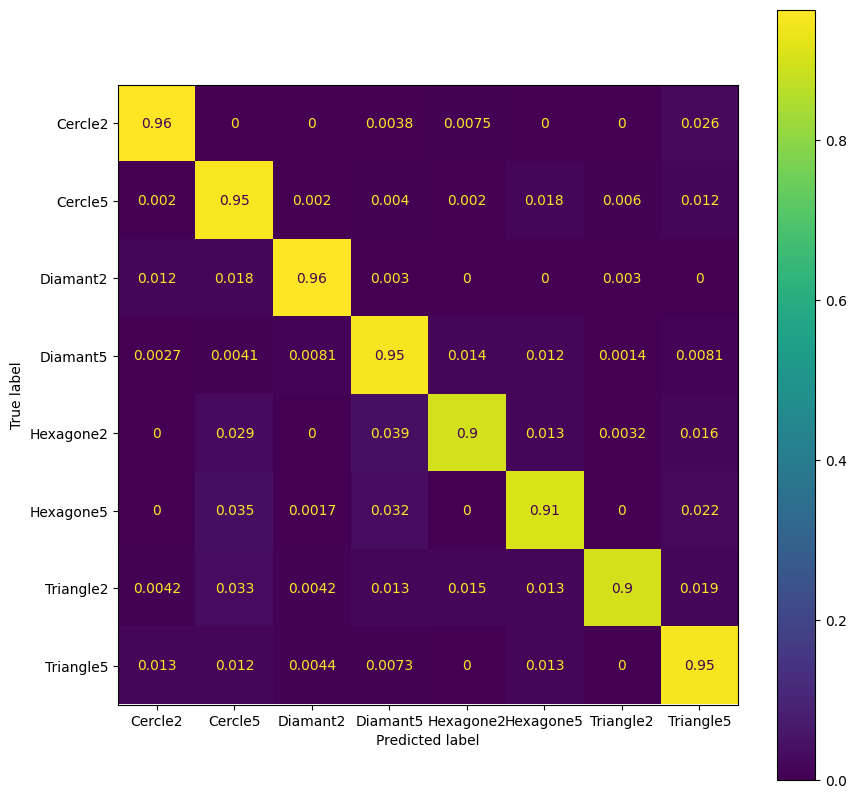

In [19]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_svm,
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

On calcule les accuracy, precision, recall et f1-score :

In [20]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm = accuracy_score(y_test.argmax(axis=1), y_pred_svm)
print('Accuracy: %f' % accuracy_svm, '\n')
# precision tp / (tp + fp)
precision_svm = precision_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('Precision: %f' % precision_svm, '\n')
# recall: tp / (tp + fn)
recall_svm = recall_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('Recall: %f' % recall_svm, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm = f1_score(y_test.argmax(axis=1), y_pred_svm, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm, '\n')

Accuracy: 0.936203 

Precision: 0.938253 

Recall: 0.936097 

F1 score: 0.936656 



#### 3- Réseau de neurone (NN) model

On réalise les imports nécessaires :

In [21]:
%pip install tensorflow
%pip install keras

import keras
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from keras.layers import BatchNormalization 
from keras.utils import np_utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


##### A-  Créer le modèle du réseau de neurone

On instancie le réseau de neurones en lui ajoutant plusieurs couches :

In [22]:
nn_learning_rate = 0.000001

NN=Sequential()
NN.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu')) # couche d'entrée
NN.add(Dense(500,activation='relu')) #
NN.add(Dense(300,activation='relu')) # couches cachées
NN.add(Dropout(0.2))                 #
NN.add(Dense(len(my_dataset.target_names),activation='softmax')) # couche de sortie
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate) # on utilise une descente du gradient avec moment
NN.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy']) # on compile le modèle

On remarque dans la cellule ci-dessus de nombreux paramètres, on peut choisir le nombre de couches cachées, le type de ces couches, le nombre de noeuds par couche ou encore l'optimisation de descente du gradient  
  
Les choix des couches sont basées sur un exemple existant avec quelques modifications pour optimiser le fonctionnement.  
Le *learning rate* a, cependant, été l'objet de nombreux de tests où le but était de maximiser l'*accuracy* en minimisant le *loss*

On affiche le sommaire du réseau de neurones créé :

In [23]:
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              1622000   
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 300)               150300    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 2408      
                                                                 
Total params: 2,275,208
Trainable params: 2,275,208
Non-trainable params: 0
_________________________________________________________________


##### B- Phase d'apprentissage

On entraine le réseau sur les données de test en utilisant les données de validation pour la propagation en arrière (*backward propagation*) :

In [24]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN.fit(x_train,y_train,validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn))

Epoch 1/20
586/586 [==============================] - 7s 11ms/step - loss: 1.9056 - accuracy: 0.1767 - val_loss: 1.8121 - val_accuracy: 0.2349
Epoch 2/20
586/586 [==============================] - 6s 11ms/step - loss: 1.7953 - accuracy: 0.2394 - val_loss: 1.7500 - val_accuracy: 0.2816
Epoch 3/20
586/586 [==============================] - 6s 11ms/step - loss: 1.7412 - accuracy: 0.2758 - val_loss: 1.7054 - val_accuracy: 0.3205
Epoch 4/20
586/586 [==============================] - 6s 11ms/step - loss: 1.7092 - accuracy: 0.3016 - val_loss: 1.6663 - val_accuracy: 0.3479
Epoch 5/20
586/586 [==============================] - 6s 11ms/step - loss: 1.6703 - accuracy: 0.3303 - val_loss: 1.6294 - val_accuracy: 0.3946
Epoch 6/20
586/586 [==============================] - 6s 11ms/step - loss: 1.6365 - accuracy: 0.3545 - val_loss: 1.5930 - val_accuracy: 0.4033
Epoch 7/20
586/586 [==============================] - 6s 11ms/step - loss: 1.6077 - accuracy: 0.3718 - val_loss: 1.5577 - val_accuracy: 0.4394

On affiche l'évolution de la perte d'entrainement et de validation :

--------------------------------------------------------------------
Evaluate the trained CNN ...


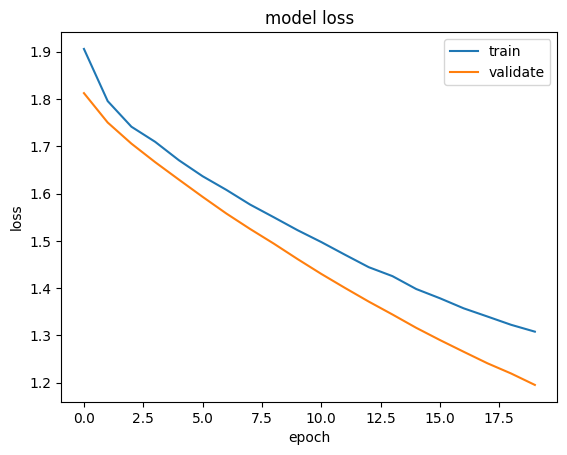

In [25]:
print('--------------------------------------------------------------------\n'
      'Evaluate the trained CNN ...')

# plotting the metrics

fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

On regarde maintenant la même chose mais pour l'*accuracy* :

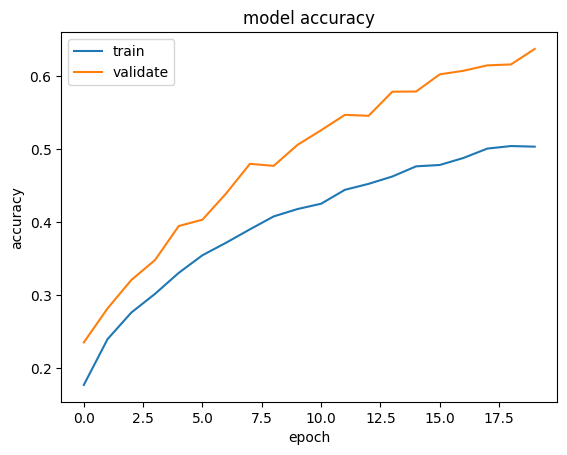

In [26]:
fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

##### C- Phase de prédiction

On teste maintenant les données de test sur le modèle entrainé :

In [27]:
start = time.time()

y_pred_nn=NN.predict(x_test)

end = time.time()

testing_time_nn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.812 secondes


##### D- Évaluation

On observe les *loss* et *accuracy* de test et d'entrainement :

In [28]:
acc_train = NN.evaluate(x_train, y_train)
print("Loss_train:", acc_train[0], " Accuracy_train:", acc_train[1])


acc_test = NN.evaluate(x_test, y_test)
print("Loss_test:", acc_test[0], " Accuracy_test:", acc_test[1])

366/366 [==============================] - 2s 5ms/step - loss: 1.1956 - accuracy: 0.6416
Loss_train: 1.195572018623352  Accuracy_train: 0.6416367888450623
122/122 [==============================] - 1s 5ms/step - loss: 1.1946 - accuracy: 0.6375
Loss_test: 1.1945781707763672  Accuracy_test: 0.6374583840370178


On trace la matrice de confusion associée aux prédictions :

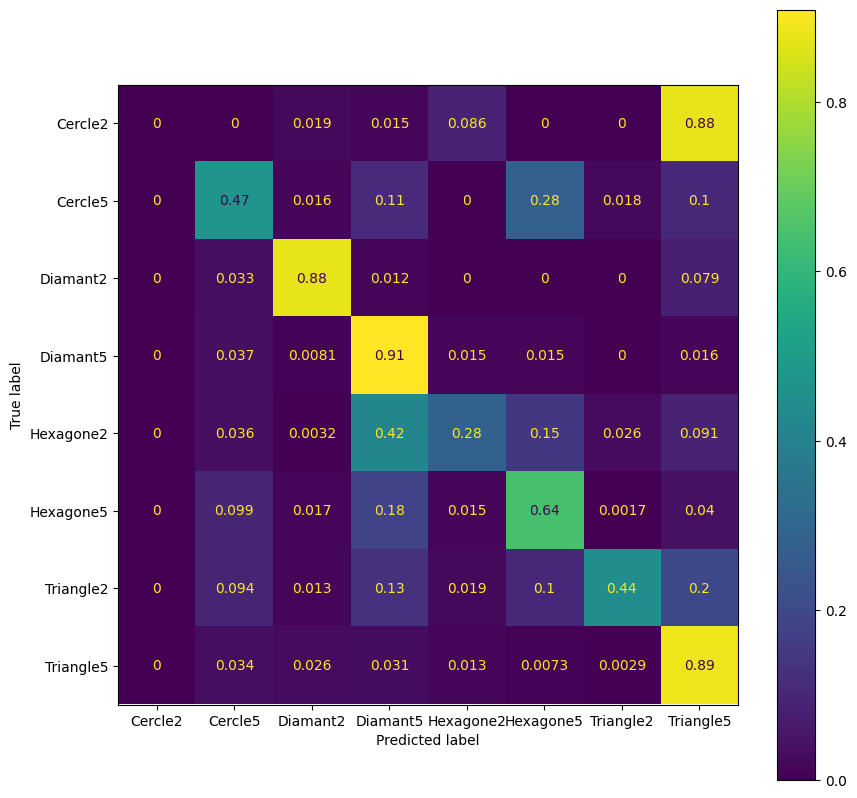

In [29]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_nn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

In [30]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn = accuracy_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn, '\n')
# precision tp / (tp + fp)
precision_nn = precision_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn, '\n')
# recall: tp / (tp + fn)
recall_nn = recall_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn = f1_score(y_test.argmax(axis=1), y_pred_nn.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn, '\n')

Accuracy: 0.637458 

Precision: 0.590372 

Recall: 0.564367 

F1 score: 0.552329 



#### 4- Réseau de neurone à convolution (CNN) model



On réalise les imports nécessaires au CNN :

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

On modifie les dimensions des données car le CNN demande 4 dimensions :

In [32]:
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val_cnn = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print(x_train_cnn.shape, x_val_cnn.shape, x_test_cnn.shape)

(11706, 1621, 1) (3903, 1621, 1) (3903, 1621, 1)


##### A-  Créer le modèle du CNN

A l'instar du NN, on instancie et on paramètre le CNN :

In [33]:
cnn_learning_rate = 0.00000000001

cnn = Sequential()
cnn.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn.add(Dense(16, activation="relu"))
cnn.add(MaxPooling1D())
cnn.add(Flatten())
cnn.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1620, 64)          192       
                                                                 
 dense_4 (Dense)             (None, 1620, 16)          1040      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 810, 16)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12960)             0         
                                                                 
 dense_5 (Dense)             (None, 8)                 103688    
                                                                 
Total params: 104,920
Trainable params: 104,920
Non-trainable params: 0
________________________________________________

##### B- Phase d'apprentissage

On entraine maintenant notre modèle sur les données de test :

In [34]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn.fit(x_train_cnn, y_train.argmax(axis=1),validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn))

Epoch 1/20
732/732 [==============================] - 11s 14ms/step - loss: 1.8501 - accuracy: 0.3153 - val_loss: 1.5807 - val_accuracy: 0.3764
Epoch 2/20
732/732 [==============================] - 10s 14ms/step - loss: 1.1381 - accuracy: 0.6365 - val_loss: 0.8471 - val_accuracy: 0.7668
Epoch 3/20
732/732 [==============================] - 10s 14ms/step - loss: 0.8098 - accuracy: 0.7555 - val_loss: 0.8003 - val_accuracy: 0.7697
Epoch 4/20
732/732 [==============================] - 10s 14ms/step - loss: 0.6769 - accuracy: 0.7939 - val_loss: 0.6945 - val_accuracy: 0.7935
Epoch 5/20
732/732 [==============================] - 10s 14ms/step - loss: 0.5869 - accuracy: 0.8268 - val_loss: 0.6209 - val_accuracy: 0.8219
Epoch 6/20
732/732 [==============================] - 10s 14ms/step - loss: 0.5311 - accuracy: 0.8473 - val_loss: 0.5379 - val_accuracy: 0.8468
Epoch 7/20
732/732 [==============================] - 10s 14ms/step - loss: 0.4930 - accuracy: 0.8573 - val_loss: 0.6503 - val_accuracy:

On affiche les *loss* et *accuracy* du modèle en fonction des epochs :

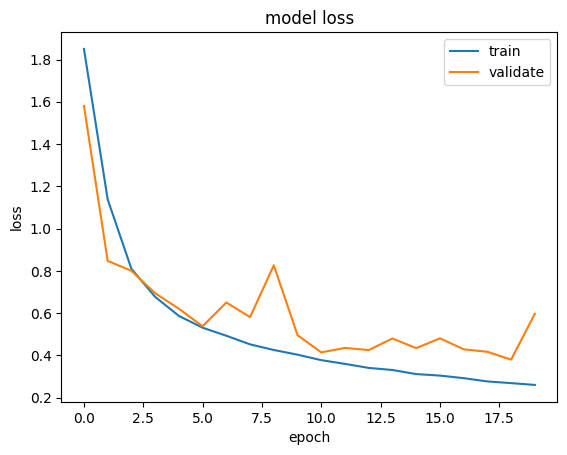

In [35]:
fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()


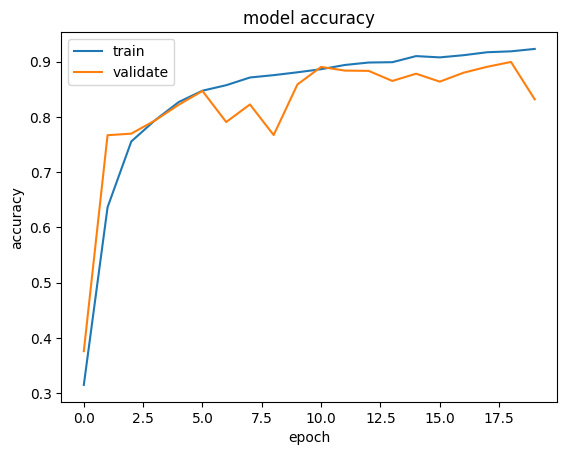

In [36]:
fig = plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')

plt.show()

##### C- Phase de prédiction

On réalise l'inférence des exemples de test sur le modèle :

In [37]:
start = time.time()

y_pred_cnn = cnn.predict(x_test_cnn)

end = time.time()

testing_time_cnn = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn))

122/122 [==============================] - 1s 10ms/step
temps de test : 1.440 secondes


##### D- Évaluation

On calcule les *loss* et *accuracy* :

In [38]:
acc_train = cnn.evaluate(x_train_cnn, y_train.argmax(axis=1))
print("Loss_train:", acc_train[0], " Accuracy_train:", acc_train[1])


acc_test = cnn.evaluate(x_test_cnn, y_test.argmax(axis=1))
print("Loss_test:", acc_test[0], " Accuracy_test:", acc_test[1])

366/366 [==============================] - 4s 10ms/step - loss: 0.4403 - accuracy: 0.8588
Loss_train: 0.44033947587013245  Accuracy_train: 0.8587903380393982
122/122 [==============================] - 1s 9ms/step - loss: 0.6163 - accuracy: 0.8183
Loss_test: 0.6162992119789124  Accuracy_test: 0.8183448910713196


On affiche maintenant la matrice de confusion :

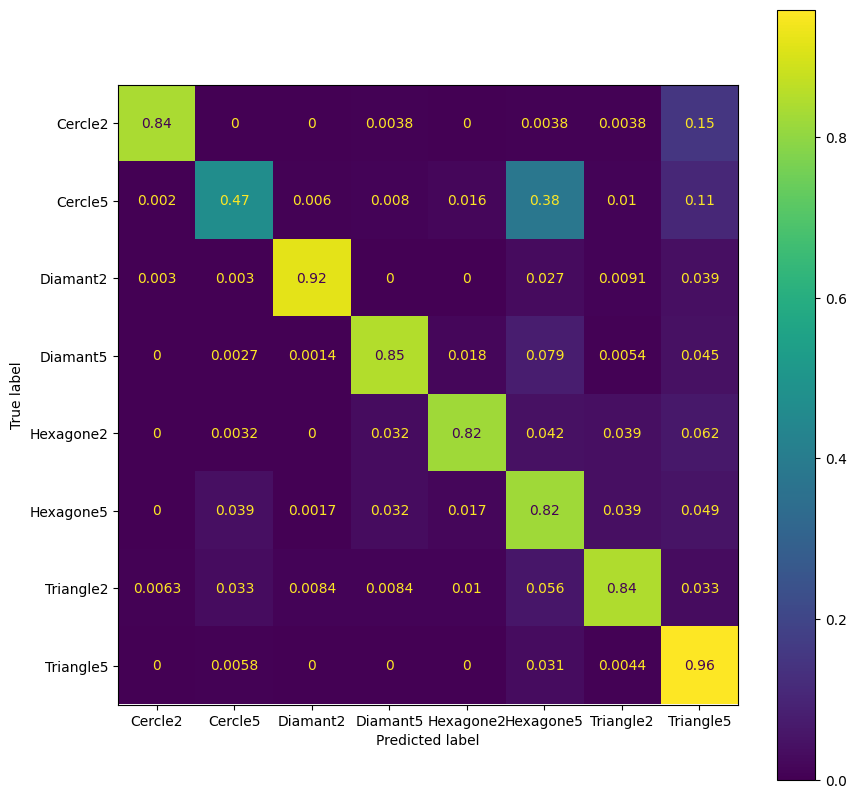

In [39]:
cf_matrix = confusion_matrix(y_true=y_test.argmax(axis=1),
                             y_pred=y_pred_cnn.argmax(axis=1),
                             normalize='true')

cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
cf_disp.plot(ax=ax)

Enfin, on calcule l'accuracy, la précision, le recall et le f1_score :

In [40]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn = accuracy_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn, '\n')
# precision tp / (tp + fp)
precision_cnn = precision_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn, '\n')
# recall: tp / (tp + fn)
recall_cnn = recall_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn = f1_score(y_test.argmax(axis=1), y_pred_cnn.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn, '\n')

Accuracy: 0.818345 

Precision: 0.857265 

Recall: 0.815587 

F1 score: 0.825400 



### Avec 60% des données

On réalise les mêmes opérations que la section précédente mais avec 60% des données d'entrainement.
  
On calcule le nombre d'images à conserver dans l'ensemble d'entrainement :

In [41]:
nb_train_images_60 = int(x_train.shape[0]*0.6)

nb_train_images_60

7023

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [42]:
import time

knn_n_neighbors = 1

start = time.time()

knn_60 = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn_60.fit(x_train_val[:nb_train_images_60,:],y_train_val[:nb_train_images_60,:]) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn_60 = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn_60))

temps d'apprentissage : 0.016 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [43]:
start = time.time()

y_pred_knn_60 = knn_60.predict(x_test)

end = time.time()

testing_time_knn_60 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn_60))
print(y_pred.shape, y_test.shape)

temps de test : 1.360 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

In [44]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn_60 = accuracy_score(y_test, y_pred_knn_60)
print('Accuracy: %f' % accuracy_knn_60, '\n')
# precision tp / (tp + fp)
precision_knn_60 = precision_score(y_test, y_pred_knn_60, average='macro', zero_division=0)
print('Precision: %f' % precision_knn_60, '\n')
# recall: tp / (tp + fn)
recall_knn_60 = recall_score(y_test, y_pred_knn_60, average='macro', zero_division=0)
print('Recall: %f' % recall_knn_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn_60 = f1_score(y_test, y_pred_knn_60, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn_60, '\n')

Accuracy: 0.894440 

Precision: 0.792794 

Recall: 0.770635 

F1 score: 0.779747 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

In [45]:
from sklearn.svm import SVC

svm_kernel = 'linear'

start = time.time()

svm_60 = SVC(kernel = svm_kernel, random_state = 0)

#Entrainer le modèle pour les données

svm_60.fit(x_train_val[:nb_train_images_60,:], y_train_val[:nb_train_images_60,:].argmax(axis=1))

end = time.time()

training_time_svm_60 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm_60))

temps d'apprentissage : 17.402 secondes


##### B- Phase de prédiction ou de test

In [46]:
start = time.time()

y_pred_svm_60 = svm_60.predict(x_test)

end = time.time()

testing_time_svm_60 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm_60))

temps de test : 6.601 secondes


##### C- Évaluation

In [47]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm_60 = accuracy_score(y_test.argmax(axis=1), y_pred_svm_60)
print('Accuracy: %f' % accuracy_svm_60, '\n')
# precision tp / (tp + fp)
precision_svm_60 = precision_score(y_test.argmax(axis=1), y_pred_svm_60, average='macro', zero_division=0)
print('Precision: %f' % precision_svm_60, '\n')
# recall: tp / (tp + fn)
recall_svm_60 = recall_score(y_test.argmax(axis=1), y_pred_svm_60, average='macro', zero_division=0)
print('Recall: %f' % recall_svm_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_60 = f1_score(y_test.argmax(axis=1), y_pred_svm_60, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm_60, '\n')

Accuracy: 0.910325 

Precision: 0.909895 

Recall: 0.907591 

F1 score: 0.907732 



#### 3- Réseau de neurone (NN) model

##### A-  Créer le modèle du réseau de neurone

In [48]:
nn_learning_rate = 0.000001

NN_60=Sequential()
NN_60.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu'))
NN_60.add(Dense(500,activation='relu'))
NN_60.add(Dense(300,activation='relu'))
NN_60.add(Dropout(0.2))
NN_60.add(Dense(len(my_dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate)
NN_60.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

##### B- Phase d'apprentissage

In [49]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN_60.fit(x_train[:nb_train_images_60,:],y_train[:nb_train_images_60,:],validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn_60 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn_60))

Epoch 1/20
352/352 [==============================] - 5s 12ms/step - loss: 1.9187 - accuracy: 0.1783 - val_loss: 1.8363 - val_accuracy: 0.2037
Epoch 2/20
352/352 [==============================] - 4s 12ms/step - loss: 1.8121 - accuracy: 0.2230 - val_loss: 1.7833 - val_accuracy: 0.2670
Epoch 3/20
352/352 [==============================] - 4s 12ms/step - loss: 1.7707 - accuracy: 0.2543 - val_loss: 1.7479 - val_accuracy: 0.3003
Epoch 4/20
352/352 [==============================] - 4s 11ms/step - loss: 1.7422 - accuracy: 0.2710 - val_loss: 1.7185 - val_accuracy: 0.3223
Epoch 5/20
352/352 [==============================] - 4s 11ms/step - loss: 1.7138 - accuracy: 0.2986 - val_loss: 1.6920 - val_accuracy: 0.3497
Epoch 6/20
352/352 [==============================] - 4s 12ms/step - loss: 1.6917 - accuracy: 0.3175 - val_loss: 1.6674 - val_accuracy: 0.3646
Epoch 7/20
352/352 [==============================] - 4s 12ms/step - loss: 1.6662 - accuracy: 0.3369 - val_loss: 1.6427 - val_accuracy: 0.3882

##### C- Phase de prédiction

In [50]:
start = time.time()

y_pred_nn_60=NN_60.predict(x_test)

end = time.time()

testing_time_nn_60 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn_60))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.778 secondes


##### D- Évaluation

In [51]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn_60 = accuracy_score(y_test.argmax(axis=1), y_pred_nn_60.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn_60, '\n')
# precision tp / (tp + fp)
precision_nn_60 = precision_score(y_test.argmax(axis=1), y_pred_nn_60.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn_60, '\n')
# recall: tp / (tp + fn)
recall_nn_60 = recall_score(y_test.argmax(axis=1), y_pred_nn_60.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn_60 = f1_score(y_test.argmax(axis=1), y_pred_nn_60.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn_60, '\n')

Accuracy: 0.549321 

Precision: 0.589413 

Recall: 0.461743 

F1 score: 0.457405 



#### 4- Réseau de neurone à convolution (CNN) model



##### A-  Créer le modèle du CNN

In [52]:
cnn_learning_rate = 0.00000000001

cnn_60 = Sequential()
cnn_60.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn_60.add(Dense(16, activation="relu"))
cnn_60.add(MaxPooling1D())
cnn_60.add(Flatten())
cnn_60.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn_60.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])

##### B- Phase d'apprentissage

In [53]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn_60.fit(x_train_cnn[:nb_train_images_60,:], y_train[:nb_train_images_60,:].argmax(axis=1),
                    validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn_60 = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn_60))

Epoch 1/20
439/439 [==============================] - 7s 15ms/step - loss: 1.9034 - accuracy: 0.2945 - val_loss: 1.6375 - val_accuracy: 0.5019
Epoch 2/20
439/439 [==============================] - 7s 15ms/step - loss: 1.3994 - accuracy: 0.5425 - val_loss: 1.5780 - val_accuracy: 0.4696
Epoch 3/20
439/439 [==============================] - 7s 15ms/step - loss: 1.0772 - accuracy: 0.6632 - val_loss: 1.0182 - val_accuracy: 0.6913
Epoch 4/20
439/439 [==============================] - 7s 15ms/step - loss: 0.8812 - accuracy: 0.7366 - val_loss: 1.3905 - val_accuracy: 0.5414
Epoch 5/20
439/439 [==============================] - 7s 15ms/step - loss: 0.7732 - accuracy: 0.7655 - val_loss: 0.7940 - val_accuracy: 0.7633
Epoch 6/20
439/439 [==============================] - 7s 15ms/step - loss: 0.6993 - accuracy: 0.7898 - val_loss: 0.6643 - val_accuracy: 0.8078
Epoch 7/20
439/439 [==============================] - 7s 15ms/step - loss: 0.6321 - accuracy: 0.8150 - val_loss: 0.6261 - val_accuracy: 0.8235

##### C- Phase de prédiction

In [54]:
start = time.time()

y_pred_cnn_60 = cnn_60.predict(x_test_cnn)

end = time.time()

testing_time_cnn_60 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn_60))

122/122 [==============================] - 1s 10ms/step
temps de test : 1.442 secondes


##### D- Évaluation

In [55]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn_60 = accuracy_score(y_test.argmax(axis=1), y_pred_cnn_60.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn_60, '\n')
# precision tp / (tp + fp)
precision_cnn_60 = precision_score(y_test.argmax(axis=1), y_pred_cnn_60.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn_60, '\n')
# recall: tp / (tp + fn)
recall_cnn_60 = recall_score(y_test.argmax(axis=1), y_pred_cnn_60.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn_60, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn_60 = f1_score(y_test.argmax(axis=1), y_pred_cnn_60.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn_60, '\n')

Accuracy: 0.868563 

Precision: 0.884503 

Recall: 0.857442 

F1 score: 0.865090 



### Avec 80% des données

On réalise les mêmes opérations que la section précédente mais avec 80% des données d'entrainement.
  
On calcule le nombre d'images à conserver dans l'ensemble d'entrainement :

In [56]:
nb_train_images_80 = int(x_train.shape[0]*0.8)

nb_train_images_80

9364

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [57]:
import time

knn_n_neighbors = 1

start = time.time()

knn_80 = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn_80.fit(x_train_val[:nb_train_images_80,:],y_train_val[:nb_train_images_80,:]) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn_80 = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn_80))

temps d'apprentissage : 0.023 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [58]:
start = time.time()

y_pred_knn_80 = knn_80.predict(x_test)

end = time.time()

testing_time_knn_80 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn_80))
print(y_pred.shape, y_test.shape)

temps de test : 1.857 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

In [59]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn_80 = accuracy_score(y_test, y_pred_knn_80)
print('Accuracy: %f' % accuracy_knn_80, '\n')
# precision tp / (tp + fp)
precision_knn_80 = precision_score(y_test, y_pred_knn_80, average='macro', zero_division=0)
print('Precision: %f' % precision_knn_80, '\n')
# recall: tp / (tp + fn)
recall_knn_80 = recall_score(y_test, y_pred_knn_80, average='macro', zero_division=0)
print('Recall: %f' % recall_knn_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn_80 = f1_score(y_test, y_pred_knn_80, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn_80, '\n')

Accuracy: 0.909557 

Precision: 0.802976 

Recall: 0.785194 

F1 score: 0.792575 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

In [60]:
from sklearn.svm import SVC

svm_kernel = 'linear'

start = time.time()

svm_80 = SVC(kernel = svm_kernel, random_state = 0)

#Entrainer le modèle pour les données

svm_80.fit(x_train_val[:nb_train_images_80,:], y_train_val[:nb_train_images_80,:].argmax(axis=1))

end = time.time()

training_time_svm_80 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm_80))

temps d'apprentissage : 26.198 secondes


##### B- Phase de prédiction ou de test

In [61]:
start = time.time()

y_pred_svm_80 = svm_80.predict(x_test)

end = time.time()

testing_time_svm_80 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm_80))

temps de test : 8.151 secondes


##### C- Évaluation

In [62]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm_80 = accuracy_score(y_test.argmax(axis=1), y_pred_svm_80)
print('Accuracy: %f' % accuracy_svm_80, '\n')
# precision tp / (tp + fp)
precision_svm_80 = precision_score(y_test.argmax(axis=1), y_pred_svm_80, average='macro', zero_division=0)
print('Precision: %f' % precision_svm_80, '\n')
# recall: tp / (tp + fn)
recall_svm_80 = recall_score(y_test.argmax(axis=1), y_pred_svm_80, average='macro', zero_division=0)
print('Recall: %f' % recall_svm_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_80 = f1_score(y_test.argmax(axis=1), y_pred_svm_80, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm_80, '\n')

Accuracy: 0.924673 

Precision: 0.924549 

Recall: 0.924706 

F1 score: 0.924206 



#### 3- Réseau de neurone (NN) model

##### A-  Créer le modèle du réseau de neurone

In [63]:
nn_learning_rate = 0.000001

NN_80=Sequential()
NN_80.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu'))
NN_80.add(Dense(500,activation='relu'))
NN_80.add(Dense(300,activation='relu'))
NN_80.add(Dropout(0.2))
NN_80.add(Dense(len(my_dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate)
NN_80.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

##### B- Phase d'apprentissage

In [64]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN_80.fit(x_train[:nb_train_images_80,:],y_train[:nb_train_images_80,:],validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn_80 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn_80))

Epoch 1/20
469/469 [==============================] - 6s 12ms/step - loss: 1.9020 - accuracy: 0.1646 - val_loss: 1.8206 - val_accuracy: 0.2683
Epoch 2/20
469/469 [==============================] - 5s 11ms/step - loss: 1.8016 - accuracy: 0.2296 - val_loss: 1.7640 - val_accuracy: 0.2941
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 1.7547 - accuracy: 0.2525 - val_loss: 1.7214 - val_accuracy: 0.3297
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 1.7222 - accuracy: 0.2831 - val_loss: 1.6866 - val_accuracy: 0.3633
Epoch 5/20
469/469 [==============================] - 5s 11ms/step - loss: 1.6896 - accuracy: 0.3024 - val_loss: 1.6550 - val_accuracy: 0.3705
Epoch 6/20
469/469 [==============================] - 6s 12ms/step - loss: 1.6706 - accuracy: 0.3112 - val_loss: 1.6273 - val_accuracy: 0.3892
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 1.6432 - accuracy: 0.3318 - val_loss: 1.6002 - val_accuracy: 0.3951

##### C- Phase de prédiction

In [65]:
start = time.time()

y_pred_nn_80=NN_80.predict(x_test)

end = time.time()

testing_time_nn_80 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn_80))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.748 secondes


##### D- Évaluation

In [66]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn_80 = accuracy_score(y_test.argmax(axis=1), y_pred_nn_80.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn_80, '\n')
# precision tp / (tp + fp)
precision_nn_80 = precision_score(y_test.argmax(axis=1), y_pred_nn_80.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn_80, '\n')
# recall: tp / (tp + fn)
recall_nn_80 = recall_score(y_test.argmax(axis=1), y_pred_nn_80.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn_80 = f1_score(y_test.argmax(axis=1), y_pred_nn_80.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn_80, '\n')

Accuracy: 0.611068 

Precision: 0.601011 

Recall: 0.535272 

F1 score: 0.532639 



#### 4- Réseau de neurone à convolution (CNN) model


##### A-  Créer le modèle du CNN

In [67]:
cnn_learning_rate = 0.00000000001

cnn_80 = Sequential()
cnn_80.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn_80.add(Dense(16, activation="relu"))
cnn_80.add(MaxPooling1D())
cnn_80.add(Flatten())
cnn_80.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn_80.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])

##### B- Phase d'apprentissage

In [68]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn_80.fit(x_train_cnn[:nb_train_images_80,:], y_train[:nb_train_images_80,:].argmax(axis=1),
                    validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn_80 = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn_80))

Epoch 1/20
586/586 [==============================] - 9s 14ms/step - loss: 1.9222 - accuracy: 0.2743 - val_loss: 1.7193 - val_accuracy: 0.3295
Epoch 2/20
586/586 [==============================] - 8s 14ms/step - loss: 1.3486 - accuracy: 0.5623 - val_loss: 1.3372 - val_accuracy: 0.5368
Epoch 3/20
586/586 [==============================] - 8s 14ms/step - loss: 0.9667 - accuracy: 0.7028 - val_loss: 1.0437 - val_accuracy: 0.6462
Epoch 4/20
586/586 [==============================] - 8s 14ms/step - loss: 0.7867 - accuracy: 0.7631 - val_loss: 2.0792 - val_accuracy: 0.4130
Epoch 5/20
586/586 [==============================] - 8s 14ms/step - loss: 0.6838 - accuracy: 0.7911 - val_loss: 0.6778 - val_accuracy: 0.7971
Epoch 6/20
586/586 [==============================] - 8s 14ms/step - loss: 0.6158 - accuracy: 0.8169 - val_loss: 0.8520 - val_accuracy: 0.7607
Epoch 7/20
586/586 [==============================] - 8s 14ms/step - loss: 0.5591 - accuracy: 0.8354 - val_loss: 0.5790 - val_accuracy: 0.8437

##### C- Phase de prédiction

In [69]:
start = time.time()

y_pred_cnn_80 = cnn_80.predict(x_test_cnn)

end = time.time()

testing_time_cnn_80 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn_80))

122/122 [==============================] - 1s 10ms/step
temps de test : 1.411 secondes


##### D- Évaluation

In [70]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn_80 = accuracy_score(y_test.argmax(axis=1), y_pred_cnn_80.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn_80, '\n')
# precision tp / (tp + fp)
precision_cnn_80 = precision_score(y_test.argmax(axis=1), y_pred_cnn_80.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn_80, '\n')
# recall: tp / (tp + fn)
recall_cnn_80 = recall_score(y_test.argmax(axis=1), y_pred_cnn_80.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn_80, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn_80 = f1_score(y_test.argmax(axis=1), y_pred_cnn_80.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn_80, '\n')

Accuracy: 0.873687 

Precision: 0.883731 

Recall: 0.862689 

F1 score: 0.867838 



### Avec 40% des données

On réalise les mêmes opérations que la section précédente mais avec 40% des données d'entrainement.
  
On calcule le nombre d'images à conserver dans l'ensemble d'entrainement :

In [71]:
nb_train_images_40 = int(x_train.shape[0]*0.4)

nb_train_images_40

4682

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [72]:
import time

knn_n_neighbors = 1

start = time.time()

knn_40 = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn_40.fit(x_train_val[:nb_train_images_40,:],y_train_val[:nb_train_images_40,:]) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn_40 = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn_40))

temps d'apprentissage : 0.014 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [73]:
start = time.time()

y_pred_knn_40 = knn_40.predict(x_test)

end = time.time()

testing_time_knn_40 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn_40))
print(y_pred.shape, y_test.shape)

temps de test : 1.173 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

In [74]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn_40 = accuracy_score(y_test, y_pred_knn_40)
print('Accuracy: %f' % accuracy_knn_40, '\n')
# precision tp / (tp + fp)
precision_knn_40 = precision_score(y_test, y_pred_knn_40, average='macro', zero_division=0)
print('Precision: %f' % precision_knn_40, '\n')
# recall: tp / (tp + fn)
recall_knn_40 = recall_score(y_test, y_pred_knn_40, average='macro', zero_division=0)
print('Recall: %f' % recall_knn_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn_40 = f1_score(y_test, y_pred_knn_40, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn_40, '\n')

Accuracy: 0.868563 

Precision: 0.771099 

Recall: 0.743928 

F1 score: 0.754474 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

In [75]:
from sklearn.svm import SVC

svm_kernel = 'linear'

start = time.time()

svm_40 = SVC(kernel = svm_kernel, random_state = 0)

#Entrainer le modèle pour les données

svm_40.fit(x_train_val[:nb_train_images_40,:], y_train_val[:nb_train_images_40,:].argmax(axis=1))

end = time.time()

training_time_svm_40 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm_40))

temps d'apprentissage : 8.439 secondes


##### B- Phase de prédiction ou de test

In [76]:
start = time.time()

y_pred_svm_40 = svm_40.predict(x_test)

end = time.time()

testing_time_svm_40 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm_40))

temps de test : 5.246 secondes


##### C- Évaluation

In [77]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm_40 = accuracy_score(y_test.argmax(axis=1), y_pred_svm_40)
print('Accuracy: %f' % accuracy_svm_40, '\n')
# precision tp / (tp + fp)
precision_svm_40 = precision_score(y_test.argmax(axis=1), y_pred_svm_40, average='macro', zero_division=0)
print('Precision: %f' % precision_svm_40, '\n')
# recall: tp / (tp + fn)
recall_svm_40 = recall_score(y_test.argmax(axis=1), y_pred_svm_40, average='macro', zero_division=0)
print('Recall: %f' % recall_svm_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_40 = f1_score(y_test.argmax(axis=1), y_pred_svm_40, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm_40, '\n')

Accuracy: 0.903920 

Precision: 0.906053 

Recall: 0.901400 

F1 score: 0.902654 



#### 3- Réseau de neurone (NN) model

##### A-  Créer le modèle du réseau de neurone

In [78]:
nn_learning_rate = 0.000001

NN_40=Sequential()
NN_40.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu'))
NN_40.add(Dense(500,activation='relu'))
NN_40.add(Dense(300,activation='relu'))
NN_40.add(Dropout(0.2))
NN_40.add(Dense(len(my_dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate)
NN_40.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

##### B- Phase d'apprentissage

In [79]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN_40.fit(x_train[:nb_train_images_40,:],y_train[:nb_train_images_40,:],validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn_40 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn_40))

Epoch 1/20
235/235 [==============================] - 4s 13ms/step - loss: 1.8929 - accuracy: 0.1764 - val_loss: 1.8397 - val_accuracy: 0.1996
Epoch 2/20
235/235 [==============================] - 3s 13ms/step - loss: 1.8178 - accuracy: 0.2091 - val_loss: 1.7982 - val_accuracy: 0.2157
Epoch 3/20
235/235 [==============================] - 3s 12ms/step - loss: 1.7824 - accuracy: 0.2287 - val_loss: 1.7737 - val_accuracy: 0.2414
Epoch 4/20
235/235 [==============================] - 3s 13ms/step - loss: 1.7652 - accuracy: 0.2358 - val_loss: 1.7527 - val_accuracy: 0.2695
Epoch 5/20
235/235 [==============================] - 3s 12ms/step - loss: 1.7405 - accuracy: 0.2595 - val_loss: 1.7333 - val_accuracy: 0.2913
Epoch 6/20
235/235 [==============================] - 3s 12ms/step - loss: 1.7236 - accuracy: 0.2674 - val_loss: 1.7155 - val_accuracy: 0.3092
Epoch 7/20
235/235 [==============================] - 3s 12ms/step - loss: 1.7138 - accuracy: 0.2766 - val_loss: 1.6995 - val_accuracy: 0.3256

##### C- Phase de prédiction

In [80]:
start = time.time()

y_pred_nn_40=NN_40.predict(x_test)

end = time.time()

testing_time_nn_40 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn_40))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.729 secondes


##### D- Évaluation

In [81]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn_40 = accuracy_score(y_test.argmax(axis=1), y_pred_nn_40.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn_40, '\n')
# precision tp / (tp + fp)
precision_nn_40 = precision_score(y_test.argmax(axis=1), y_pred_nn_40.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn_40, '\n')
# recall: tp / (tp + fn)
recall_nn_40 = recall_score(y_test.argmax(axis=1), y_pred_nn_40.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn_40 = f1_score(y_test.argmax(axis=1), y_pred_nn_40.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn_40, '\n')

Accuracy: 0.459903 

Precision: 0.506162 

Recall: 0.369555 

F1 score: 0.352390 



#### 4- Réseau de neurone à convolution (CNN) model



##### A-  Créer le modèle du CNN

In [82]:
cnn_learning_rate = 0.00000000001

cnn_40 = Sequential()
cnn_40.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn_40.add(Dense(16, activation="relu"))
cnn_40.add(MaxPooling1D())
cnn_40.add(Flatten())
cnn_40.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn_40.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])

##### B- Phase d'apprentissage

In [83]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn_40.fit(x_train_cnn[:nb_train_images_40,:], y_train[:nb_train_images_40,:].argmax(axis=1),
                    validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn_40 = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn_40))

Epoch 1/20
293/293 [==============================] - 5s 17ms/step - loss: 1.9950 - accuracy: 0.2249 - val_loss: 1.9008 - val_accuracy: 0.2626
Epoch 2/20
293/293 [==============================] - 7s 22ms/step - loss: 1.7350 - accuracy: 0.3787 - val_loss: 1.5052 - val_accuracy: 0.5050
Epoch 3/20
293/293 [==============================] - 5s 16ms/step - loss: 1.3880 - accuracy: 0.5463 - val_loss: 2.1148 - val_accuracy: 0.2921
Epoch 4/20
293/293 [==============================] - 5s 16ms/step - loss: 1.1850 - accuracy: 0.6322 - val_loss: 0.9859 - val_accuracy: 0.7036
Epoch 5/20
293/293 [==============================] - 5s 15ms/step - loss: 1.0525 - accuracy: 0.6788 - val_loss: 1.1293 - val_accuracy: 0.6377
Epoch 6/20
293/293 [==============================] - 5s 15ms/step - loss: 0.9568 - accuracy: 0.7132 - val_loss: 0.8828 - val_accuracy: 0.7481
Epoch 7/20
293/293 [==============================] - 5s 15ms/step - loss: 0.8817 - accuracy: 0.7339 - val_loss: 1.2727 - val_accuracy: 0.6454

##### C- Phase de prédiction

In [84]:
start = time.time()

y_pred_cnn_40 = cnn_40.predict(x_test_cnn)

end = time.time()

testing_time_cnn_40 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn_40))

122/122 [==============================] - 1s 9ms/step
temps de test : 1.352 secondes


##### D- Évaluation

In [85]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn_40 = accuracy_score(y_test.argmax(axis=1), y_pred_cnn_40.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn_40, '\n')
# precision tp / (tp + fp)
precision_cnn_40 = precision_score(y_test.argmax(axis=1), y_pred_cnn_40.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn_40, '\n')
# recall: tp / (tp + fn)
recall_cnn_40 = recall_score(y_test.argmax(axis=1), y_pred_cnn_40.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn_40, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn_40 = f1_score(y_test.argmax(axis=1), y_pred_cnn_40.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn_40, '\n')

Accuracy: 0.794517 

Precision: 0.834293 

Recall: 0.784643 

F1 score: 0.793142 



### Avec 20% de données

On réalise les mêmes opérations que la section précédente mais avec 20% des données d'entrainement.
  
On calcule le nombre d'images à conserver dans l'ensemble d'entrainement :

In [86]:
nb_train_images_20 = int(x_train.shape[0]*0.2)

nb_train_images_20

2341

#### 1- K-nearest neighbors algorithm (KNN)

##### A- Phase d'apprentissage

In [87]:
import time

knn_n_neighbors = 1

start = time.time()

knn_20 = KNeighborsClassifier(n_neighbors=knn_n_neighbors)

# on entraine le modèle
knn_20.fit(x_train_val[:nb_train_images_20,:],y_train_val[:nb_train_images_20,:]) # on combine l'ensemble d'entrainement et de validation

end = time.time()

training_time_knn_20 = end - start
print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_knn_20))

temps d'apprentissage : 0.018 secondes


##### B- Phase de prédiction ou de test

on réalise la prédiction avec le modèle précédemment créé :

In [88]:
start = time.time()

y_pred_knn_20 = knn_20.predict(x_test)

end = time.time()

testing_time_knn_20 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_knn_20))
print(y_pred.shape, y_test.shape)

temps de test : 0.882 secondes
(3903, 8) (3903, 8)


##### C- Évaluation

In [89]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_knn_20 = accuracy_score(y_test, y_pred_knn_20)
print('Accuracy: %f' % accuracy_knn_20, '\n')
# precision tp / (tp + fp)
precision_knn_20 = precision_score(y_test, y_pred_knn_20, average='macro', zero_division=0)
print('Precision: %f' % precision_knn_20, '\n')
# recall: tp / (tp + fn)
recall_knn_20 = recall_score(y_test, y_pred_knn_20, average='macro', zero_division=0)
print('Recall: %f' % recall_knn_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_knn_20 = f1_score(y_test, y_pred_knn_20, average='macro', zero_division=0)
print('F1 score: %f' % f1_knn_20, '\n')

Accuracy: 0.803997 

Precision: 0.718592 

Recall: 0.683493 

F1 score: 0.695673 



#### 2- Support vector machine (SVM) model

##### A- Phase d'apprentissage

In [90]:
from sklearn.svm import SVC

svm_kernel = 'linear'

start = time.time()

svm_20 = SVC(kernel = svm_kernel, random_state = 0)

#Entrainer le modèle pour les données

svm_20.fit(x_train_val[:nb_train_images_20,:], y_train_val[:nb_train_images_20,:].argmax(axis=1))

end = time.time()

training_time_svm_20 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_svm_20))

temps d'apprentissage : 2.883 secondes


##### B- Phase de prédiction ou de test

In [91]:
start = time.time()

y_pred_svm_20 = svm_20.predict(x_test)

end = time.time()

testing_time_svm_20 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_svm_20))

temps de test : 3.450 secondes


##### C- Évaluation

In [92]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_svm_20 = accuracy_score(y_test.argmax(axis=1), y_pred_svm_20)
print('Accuracy: %f' % accuracy_svm_20, '\n')
# precision tp / (tp + fp)
precision_svm_20 = precision_score(y_test.argmax(axis=1), y_pred_svm_20, average='macro', zero_division=0)
print('Precision: %f' % precision_svm_20, '\n')
# recall: tp / (tp + fn)
recall_svm_20 = recall_score(y_test.argmax(axis=1), y_pred_svm_20, average='macro', zero_division=0)
print('Recall: %f' % recall_svm_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_svm_20 = f1_score(y_test.argmax(axis=1), y_pred_svm_20, average='macro', zero_division=0)
print('F1 score: %f' % f1_svm_20, '\n')

Accuracy: 0.872918 

Precision: 0.875499 

Recall: 0.867484 

F1 score: 0.869808 



#### 3- Réseau de neurone (NN) model

##### A-  Créer le modèle du réseau de neurone

In [93]:
nn_learning_rate = 0.000001

NN_20=Sequential()
NN_20.add(Dense(1000,input_dim=len(my_dataset.feature_names),activation='relu'))
NN_20.add(Dense(500,activation='relu'))
NN_20.add(Dense(300,activation='relu'))
NN_20.add(Dropout(0.2))
NN_20.add(Dense(len(my_dataset.target_names),activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=nn_learning_rate)
NN_20.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

##### B- Phase d'apprentissage

In [94]:
nn_nb_epochs = 20
nn_batch_size = 20

start = time.time()

history= NN_20.fit(x_train[:nb_train_images_20,:],y_train[:nb_train_images_20,:],validation_data=(x_val,y_val), batch_size=nn_batch_size,epochs=nn_nb_epochs,verbose=1)

end = time.time()

training_time_nn_20 = end - start

print('temps d\'apprentissage : {:.3f} secondes'.format(training_time_nn_20))

Epoch 1/20
118/118 [==============================] - 2s 16ms/step - loss: 1.9618 - accuracy: 0.1393 - val_loss: 1.9113 - val_accuracy: 0.1499
Epoch 2/20
118/118 [==============================] - 2s 14ms/step - loss: 1.8842 - accuracy: 0.1679 - val_loss: 1.8603 - val_accuracy: 0.1735
Epoch 3/20
118/118 [==============================] - 2s 14ms/step - loss: 1.8410 - accuracy: 0.1824 - val_loss: 1.8316 - val_accuracy: 0.1916
Epoch 4/20
118/118 [==============================] - 2s 16ms/step - loss: 1.8133 - accuracy: 0.2042 - val_loss: 1.8123 - val_accuracy: 0.2206
Epoch 5/20
118/118 [==============================] - 2s 16ms/step - loss: 1.8009 - accuracy: 0.2076 - val_loss: 1.7968 - val_accuracy: 0.2490
Epoch 6/20
118/118 [==============================] - 2s 16ms/step - loss: 1.7840 - accuracy: 0.2204 - val_loss: 1.7832 - val_accuracy: 0.2703
Epoch 7/20
118/118 [==============================] - 2s 16ms/step - loss: 1.7777 - accuracy: 0.2307 - val_loss: 1.7714 - val_accuracy: 0.2806

##### C- Phase de prédiction

In [95]:
start = time.time()

y_pred_nn_20=NN_20.predict(x_test)

end = time.time()

testing_time_nn_20 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_nn_20))

122/122 [==============================] - 1s 5ms/step
temps de test : 0.812 secondes


##### D- Évaluation

In [96]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_nn_20 = accuracy_score(y_test.argmax(axis=1), y_pred_nn_20.argmax(axis=1))
print('Accuracy: %f' % accuracy_nn_20, '\n')
# precision tp / (tp + fp)
precision_nn_20 = precision_score(y_test.argmax(axis=1), y_pred_nn_20.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_nn_20, '\n')
# recall: tp / (tp + fn)
recall_nn_20 = recall_score(y_test.argmax(axis=1), y_pred_nn_20.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_nn_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_nn_20 = f1_score(y_test.argmax(axis=1), y_pred_nn_20.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_nn_20, '\n')

Accuracy: 0.415578 

Precision: 0.415568 

Recall: 0.323338 

F1 score: 0.293565 



#### 4- Réseau de neurone à convolution (CNN) model



##### A-  Créer le modèle du CNN

In [97]:
cnn_learning_rate = 0.00000000001

cnn_20 = Sequential()
cnn_20.add(Conv1D(64, 2, activation="relu", input_shape=(x_train_cnn.shape[1],1)))
cnn_20.add(Dense(16, activation="relu"))
cnn_20.add(MaxPooling1D())
cnn_20.add(Flatten())
cnn_20.add(Dense(len(my_dataset.target_names), activation = 'softmax'))
optimizer = keras.optimizers.SGD(learning_rate=cnn_learning_rate)
cnn_20.compile(loss = 'sparse_categorical_crossentropy', 
     optimizer = "sgd",    #adam           
              metrics = ['accuracy'])

##### B- Phase d'apprentissage

In [98]:
cnn_batch_size = 16
cnn_nb_epochs = 20

start = time.time()

history=cnn_20.fit(x_train_cnn[:nb_train_images_20,:], y_train[:nb_train_images_20,:].argmax(axis=1),
                    validation_data=(x_val_cnn,y_val.argmax(axis=1)), batch_size=cnn_batch_size,epochs=cnn_nb_epochs, verbose=1)

end = time.time()

training_time_cnn_20 = end - start

print('temps d\'entrainement : {:.3f} secondes'.format(training_time_cnn_20))

Epoch 1/20
147/147 [==============================] - 4s 24ms/step - loss: 2.0332 - accuracy: 0.1978 - val_loss: 2.0213 - val_accuracy: 0.1773
Epoch 2/20
147/147 [==============================] - 3s 22ms/step - loss: 1.9753 - accuracy: 0.2396 - val_loss: 1.9599 - val_accuracy: 0.1783
Epoch 3/20
147/147 [==============================] - 3s 20ms/step - loss: 1.8544 - accuracy: 0.3400 - val_loss: 1.9642 - val_accuracy: 0.1332
Epoch 4/20
147/147 [==============================] - 3s 18ms/step - loss: 1.6440 - accuracy: 0.4242 - val_loss: 1.8562 - val_accuracy: 0.2695
Epoch 5/20
147/147 [==============================] - 3s 20ms/step - loss: 1.4377 - accuracy: 0.5130 - val_loss: 2.1771 - val_accuracy: 0.2631
Epoch 6/20
147/147 [==============================] - 3s 20ms/step - loss: 1.2986 - accuracy: 0.5780 - val_loss: 1.1783 - val_accuracy: 0.6759
Epoch 7/20
147/147 [==============================] - 3s 20ms/step - loss: 1.1784 - accuracy: 0.6314 - val_loss: 1.6220 - val_accuracy: 0.4468

##### C- Phase de prédiction

In [99]:
start = time.time()

y_pred_cnn_20 = cnn_20.predict(x_test_cnn)

end = time.time()

testing_time_cnn_20 = end - start

print('temps de test : {:.3f} secondes'.format(testing_time_cnn_20))

122/122 [==============================] - 1s 9ms/step
temps de test : 1.309 secondes


##### D- Évaluation

In [100]:
# accuracy: (tp + tn) / (fp + fn)
accuracy_cnn_20 = accuracy_score(y_test.argmax(axis=1), y_pred_cnn_20.argmax(axis=1))
print('Accuracy: %f' % accuracy_cnn_20, '\n')
# precision tp / (tp + fp)
precision_cnn_20 = precision_score(y_test.argmax(axis=1), y_pred_cnn_20.argmax(axis=1), average='macro', zero_division=0)
print('Precision: %f' % precision_cnn_20, '\n')
# recall: tp / (tp + fn)
recall_cnn_20 = recall_score(y_test.argmax(axis=1), y_pred_cnn_20.argmax(axis=1), average='macro', zero_division=0)
print('Recall: %f' % recall_cnn_20, '\n')
# f1: 2 tp / (2 tp + fp + fn)
f1_cnn_20 = f1_score(y_test.argmax(axis=1), y_pred_cnn_20.argmax(axis=1), average='macro', zero_division=0)
print('F1 score: %f' % f1_cnn_20, '\n')

Accuracy: 0.797079 

Precision: 0.801400 

Recall: 0.784034 

F1 score: 0.789540 



## Comparaison

In [101]:
%pip install prettytable

from prettytable import PrettyTable

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
t = PrettyTable(['result','KNN','SVM','NN','CNN'])

knn_hp = 'n_neightbors : {}'.format(knn_n_neighbors)
svm_hp = 'kernel : {}'.format(svm_kernel)
nn_hp = 'learning_rate : {}\nbatch size : {}\nepochs : {}\n'.format(nn_learning_rate,nn_batch_size,nn_nb_epochs)
cnn_hp = 'learning_rate : {}\nbatch size : {}\nepochs : {}\n'.format(cnn_learning_rate,cnn_batch_size,cnn_nb_epochs)


t.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp])
t.add_row(['training time : ',training_time_knn,training_time_svm,training_time_nn,training_time_cnn])
t.add_row(['testing time : ',testing_time_knn,testing_time_svm,testing_time_nn,testing_time_cnn])
t.add_row(['accuracy : ',accuracy_knn,accuracy_svm,accuracy_nn,accuracy_cnn])
t.add_row(['precision : ',precision_knn,precision_svm,precision_nn,precision_cnn])
t.add_row(['recall : ',recall_knn,recall_svm,recall_nn,recall_cnn])
t.add_row(['f1_score : ',f1_knn,f1_svm,f1_nn,f1_cnn])
t.align = 'r'
t.float_format = '.3'
print(t)

+--------------------+------------------+-----------------+-----------------------+-----------------------+
|             result |              KNN |             SVM |                    NN |                   CNN |
+--------------------+------------------+-----------------+-----------------------+-----------------------+
| hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 |
|                    |                  |                 |       batch size : 20 |       batch size : 16 |
|                    |                  |                 |           epochs : 20 |           epochs : 20 |
|                    |                  |                 |                       |                       |
|   training time :  |            0.040 |          62.655 |               129.263 |               198.394 |
|    testing time :  |            2.298 |          11.685 |                 0.812 |                 1.440 |
|        accuracy :  |      

In [103]:
t_80 = PrettyTable(['result for 80% of training data','KNN','SVM','NN','CNN'])

t_80.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp])
t_80.add_row(['training time : ',training_time_knn_80,training_time_svm_80,training_time_nn_80,training_time_cnn_80])
t_80.add_row(['testing time : ',testing_time_knn_80,testing_time_svm_80,testing_time_nn_80,testing_time_cnn_80])
t_80.add_row(['accuracy : ',accuracy_knn_80,accuracy_svm_80,accuracy_nn_80,accuracy_cnn_80])
t_80.add_row(['precision : ',precision_knn_80,precision_svm_80,precision_nn_80,precision_cnn_80])
t_80.add_row(['recall : ',recall_knn_80,recall_svm_80,recall_nn_80,recall_cnn_80])
t_80.add_row(['f1_score : ',f1_knn_80,f1_svm_80,f1_nn_80,f1_cnn_80])
t_80.align = 'r'
t_80.float_format = '.3'
print(t_80)

+---------------------------------+------------------+-----------------+-----------------------+-----------------------+
| result for 80% of training data |              KNN |             SVM |                    NN |                   CNN |
+---------------------------------+------------------+-----------------+-----------------------+-----------------------+
|              hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 |
|                                 |                  |                 |       batch size : 20 |       batch size : 16 |
|                                 |                  |                 |           epochs : 20 |           epochs : 20 |
|                                 |                  |                 |                       |                       |
|                training time :  |            0.023 |          26.198 |               106.948 |               169.247 |
|                 testing time :

In [104]:
t_60 = PrettyTable(['result for 60% of training data','KNN','SVM','NN','CNN'])

t_60.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp])
t_60.add_row(['training time : ',training_time_knn_60,training_time_svm_60,training_time_nn_60,training_time_cnn_60])
t_60.add_row(['testing time : ',testing_time_knn_60,testing_time_svm_60,testing_time_nn_60,testing_time_cnn_60])
t_60.add_row(['accuracy : ',accuracy_knn_60,accuracy_svm_60,accuracy_nn_60,accuracy_cnn_60])
t_60.add_row(['precision : ',precision_knn_60,precision_svm_60,precision_nn_60,precision_cnn_60])
t_60.add_row(['recall : ',recall_knn_60,recall_svm_60,recall_nn_60,recall_cnn_60])
t_60.add_row(['f1_score : ',f1_knn_60,f1_svm_60,f1_nn_60,f1_cnn_60])
t_60.align = 'r'
t_60.float_format = '.3'
print(t_60)

+---------------------------------+------------------+-----------------+-----------------------+-----------------------+
| result for 60% of training data |              KNN |             SVM |                    NN |                   CNN |
+---------------------------------+------------------+-----------------+-----------------------+-----------------------+
|              hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 |
|                                 |                  |                 |       batch size : 20 |       batch size : 16 |
|                                 |                  |                 |           epochs : 20 |           epochs : 20 |
|                                 |                  |                 |                       |                       |
|                training time :  |            0.016 |          17.402 |                82.473 |               133.488 |
|                 testing time :

In [105]:
t_40 = PrettyTable(['result for 40% of training data','KNN','SVM','NN','CNN'])

t_40.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp])
t_40.add_row(['training time : ',training_time_knn_40,training_time_svm_40,training_time_nn_40,training_time_cnn_40])
t_40.add_row(['testing time : ',testing_time_knn_40,testing_time_svm_40,testing_time_nn_40,testing_time_cnn_40])
t_40.add_row(['accuracy : ',accuracy_knn_40,accuracy_svm_40,accuracy_nn_40,accuracy_cnn_40])
t_40.add_row(['precision : ',precision_knn_40,precision_svm_40,precision_nn_40,precision_cnn_40])
t_40.add_row(['recall : ',recall_knn_40,recall_svm_40,recall_nn_40,recall_cnn_40])
t_40.add_row(['f1_score : ',f1_knn_40,f1_svm_40,f1_nn_40,f1_cnn_40])
t_40.align = 'r'
t_40.float_format = '.3'
print(t_40)

+---------------------------------+------------------+-----------------+-----------------------+-----------------------+
| result for 40% of training data |              KNN |             SVM |                    NN |                   CNN |
+---------------------------------+------------------+-----------------+-----------------------+-----------------------+
|              hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 |
|                                 |                  |                 |       batch size : 20 |       batch size : 16 |
|                                 |                  |                 |           epochs : 20 |           epochs : 20 |
|                                 |                  |                 |                       |                       |
|                training time :  |            0.014 |           8.439 |                59.446 |                93.591 |
|                 testing time :

In [106]:
t_20 = PrettyTable(['result for 20% of training data','KNN','SVM','NN','CNN'])

t_20.add_row(['hyperparameters : ',knn_hp,svm_hp,nn_hp,cnn_hp])
t_20.add_row(['training time : ',training_time_knn_20,training_time_svm_20,training_time_nn_20,training_time_cnn_20])
t_20.add_row(['testing time : ',testing_time_knn_20,testing_time_svm_20,testing_time_nn_20,testing_time_cnn_20])
t_20.add_row(['accuracy : ',accuracy_knn_20,accuracy_svm_20,accuracy_nn_20,accuracy_cnn_20])
t_20.add_row(['precision : ',precision_knn_20,precision_svm_20,precision_nn_20,precision_cnn_20])
t_20.add_row(['recall : ',recall_knn_20,recall_svm_20,recall_nn_20,recall_cnn_20])
t_20.add_row(['f1_score : ',f1_knn_20,f1_svm_20,f1_nn_20,f1_cnn_20])
t_20.align = 'r'
t_20.float_format = '.3'
print(t_20)

+---------------------------------+------------------+-----------------+-----------------------+-----------------------+
| result for 20% of training data |              KNN |             SVM |                    NN |                   CNN |
+---------------------------------+------------------+-----------------+-----------------------+-----------------------+
|              hyperparameters :  | n_neightbors : 1 | kernel : linear | learning_rate : 1e-06 | learning_rate : 1e-11 |
|                                 |                  |                 |       batch size : 20 |       batch size : 16 |
|                                 |                  |                 |           epochs : 20 |           epochs : 20 |
|                                 |                  |                 |                       |                       |
|                training time :  |            0.018 |           2.883 |                38.365 |                60.468 |
|                 testing time :